# **NLP Project**

### Dataset downloading

In [1]:
import os
DATASET_PATH = "../dataset"

if not os.path.isdir(DATASET_PATH):
    !wget -nc -P ../ https://allenai.org/data/proofwriter
    !unzip -d ../ ../proofwriter
    !mv ../proofwriter-dataset-V2020.12.3 $DATASET_PATH
    !rm ../proofwriter

### Model loading

In [1]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
 
torch.random.manual_seed(0)

model_name = "mistralai/Mistral-7B-Instruct-v0.1" # "microsoft/Phi-4-mini-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",  # oppure "bfloat16" se supportato
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Caricamento tokenizer e modello
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    # torch_dtype=torch.float16,
    torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="eager",
    output_attentions=True
).to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name)
 
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    batch_size=1,
    device_map="auto"
)

generation_args = {
    "max_new_tokens": 4,
    "return_full_text": False,
    "do_sample": False,
    "pad_token_id" : "eos_token_id",
}


/home/mazzon/Desktop/NLP/nlp_project2/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


### Dataset loading

In [2]:
from data_loading import *
dataset = ProofWriterDataset(None, "depth-3/meta-train.jsonl", dataset_path="../dataset/OWA/")

### Execution

In [3]:
example_index = 14
example_elem = dataset[example_index]

def bool_to_bin(b):
    assert b in ["True", "False"], b
    return int(b == "True")

y_true = []
y_pred = []

prompts = []

for i, e in enumerate(dataset):
    if i == example_index: continue
    if i > 50: break

    y_true.append(bool_to_bin(e["label"]))
    prompt, _ = build_one_shot_prompt(e, example_elem)
    prompts.append(prompt)


In [ ]:
for i, res in enumerate(pipe(prompts, **generation_args)):
    # print(res)
    try:
        generated_text = res[0]["generated_text"]
        y_pred.append(bool_to_bin(generated_text.split()[0]))
    except:
        print(i)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.52
Precision: 1.00
Recall: 0.04
F1-score: 0.08


In [4]:
# TEST
prompt, prompt_segmentation = build_one_shot_prompt(e, example_elem)

encoding = tokenizer(prompt, return_offsets_mapping=True, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
offsets = encoding["offset_mapping"][0]

outputs = model(**encoding.to("cuda"))

In [129]:
from functools import reduce

attn = outputs.attentions[-1][0, 0].detach().to(torch.float32).cpu().numpy()

group_indices_on_characters = reduce(lambda acc, x : acc + [x[1]], prompt_segmentation.values(), [0])

i = 0
group_indices_on_tokens = []
for gi in group_indices_on_characters:
    while offsets[i][1] < gi: i += 1
    group_indices_on_tokens.append(i)

attention_to_group = attn[:, group_indices_on_tokens].sum()

In [130]:
group_indices_on_characters

[0, 211, 219, 957, 995, 999, 1028, 1717, 1763]

In [131]:
group_indices_on_tokens

[0, 48, 50, 260, 274, 276, 284, 477, 490]

In [132]:
def to_couples(l):
    if len(l) == 2: return [(l[0], l[1])]
    return [(l[0], l[1])] + to_couples(l[1:])

groups_intervals = to_couples(group_indices_on_tokens)
groups_intervals

[(0, 48),
 (48, 50),
 (50, 260),
 (260, 274),
 (274, 276),
 (276, 284),
 (284, 477),
 (477, 490)]

In [133]:
group_attention = np.zeros((1, len(prompt_segmentation)))

for i, (start, end) in enumerate(groups_intervals):
    values = attn[-1][start:end]
    group_attention[0][i] = values.mean()

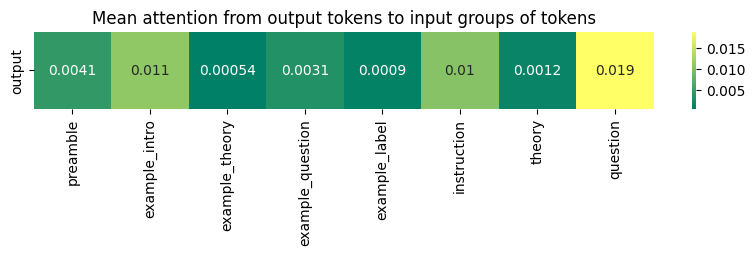

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 1))
sns.heatmap(group_attention, xticklabels=list(prompt_segmentation.keys()), yticklabels=["output"], cmap="summer", annot=True)
plt.title("Mean attention from output tokens to input groups of tokens")
plt.show()

In [110]:
attn_all_layers = outputs.attentions

# Numero di token del prompt
prompt_len = encoding["input_ids"].shape[1]

# Prendiamo l’ultimo layer (più semantico)
last_layer_attn = attn_all_layers[-1]  # [batch, num_heads, seq_len, seq_len]

# Media sulle head
attn_mean = last_layer_attn.mean(dim=1)  # [batch, seq_len, seq_len]

# Riga corrispondente all’ultimo token generato
last_token_attn = attn_mean[0, -1]  # [seq_len]

# Ora isoliamo solo le colonne del prompt (output→input)
prompt_attn = last_token_attn[:prompt_len]

# Visualizziamo i token del prompt con i rispettivi pesi
tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
for tok, score in zip(tokens, prompt_attn.tolist()):
    print(f"{tok:15s} -> {score:.4f}")


<s>             -> 0.1387
▁You            -> 0.0189
▁will           -> 0.0021
▁be             -> 0.0017
▁shown          -> 0.0011
▁a              -> 0.0009
▁theory         -> 0.0008
▁and            -> 0.0009
▁a              -> 0.0009
▁question       -> 0.0006
.               -> 0.0009
▁Your           -> 0.0025
▁task           -> 0.0006
▁is             -> 0.0008
▁to             -> 0.0016
▁evaluate       -> 0.0017
▁the            -> 0.0012
▁question       -> 0.0005
▁based          -> 0.0011
▁on             -> 0.0002
▁the            -> 0.0004
▁theory         -> 0.0006
.               -> 0.0013
<0x0A>          -> 0.0645
Res             -> 0.0058
pond            -> 0.0064
▁with           -> 0.0023
▁only           -> 0.0046
▁one            -> 0.0054
▁word           -> 0.0023
:               -> 0.0026
▁either         -> 0.0119
▁True           -> 0.0172
▁or             -> 0.0068
▁False          -> 0.0164
.               -> 0.0052
▁Do             -> 0.0034
▁not            -> 0.0026
▁include    